In [22]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
import itertools

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) 

Random Seed:  999


In [23]:
dataroot = "data/Covid19-dataset/train"
workers = 2
ngpu = 1
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 500
lr = 0.0002
beta1 = 0.5

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [24]:
def create_dataset(dataroot,image_size,batch_size,workers):
    dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=workers)
    return dataloader

dataloader = create_dataset(dataroot,image_size,batch_size,workers)

In [25]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [26]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [27]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [28]:
def load_model_and_plot(gen_path,dis_plot,lr,bs):
    # Loading the models
    netG = Generator(ngpu).to(device)
    netG.load_state_dict(torch.load(gen_path))
    netD = Discriminator(ngpu).to(device)
    netD.load_state_dict(torch.load(dis_plot))
    
    # Initialize the ``BCELoss`` function
    criterion = nn.BCELoss()

    # Create batch of latent vectors that we will use to visualize
    #  the progression of the generator
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    
    # Grab a batch of real images from the dataloader
    real_batch = next(iter(dataloader))

    # Generate random noise vectors
    with torch.no_grad():
        noise = torch.randn(64, nz, 1, 1, device=device)
    fake_images = netG(noise).detach().cpu()
    print(f'Generator and Discriminator Comparison for Learning Rate - {lr} and Batch size - {bs}')
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
    plt.show()



Generator and Discriminator Comparison for Learning Rate - 0.001 and Batch size - 64


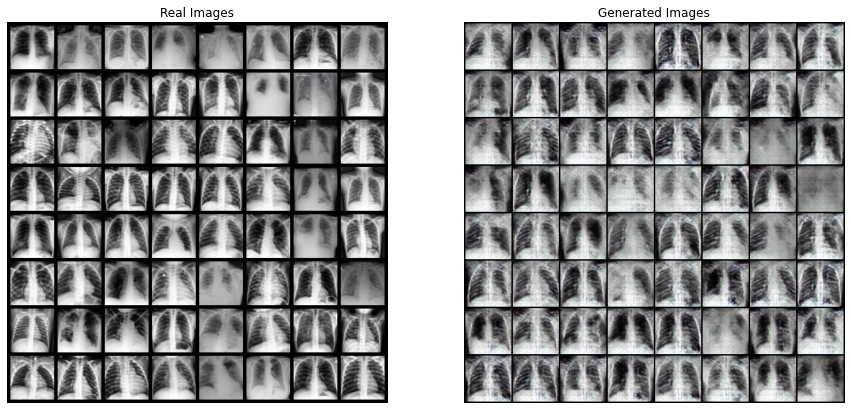

Generator and Discriminator Comparison for Learning Rate - 0.001 and Batch size - 128


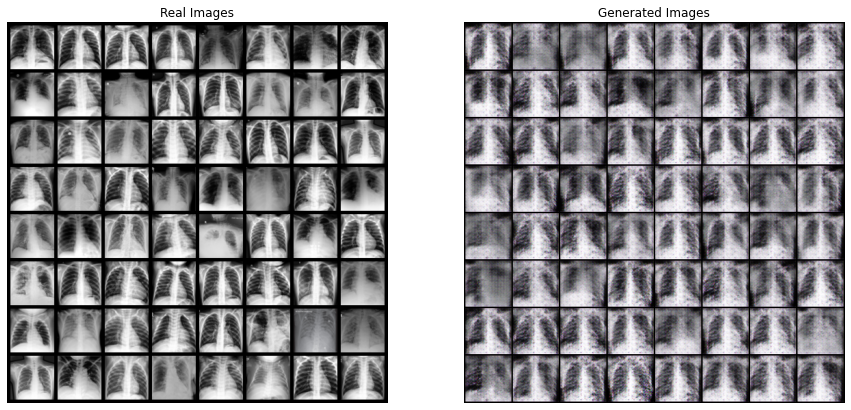

Generator and Discriminator Comparison for Learning Rate - 0.001 and Batch size - 256


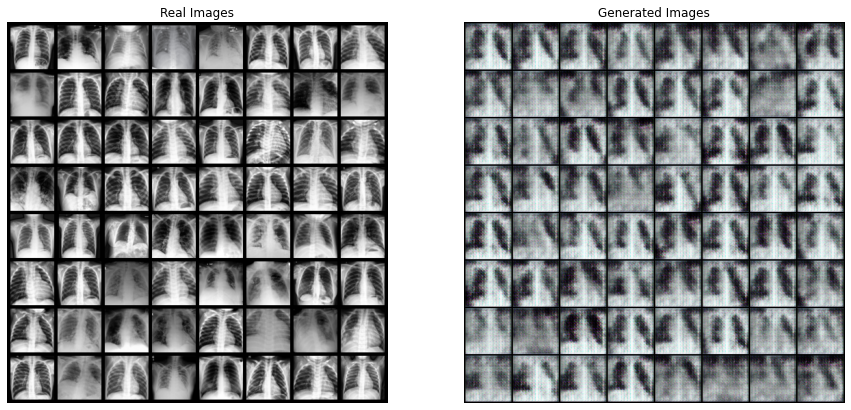

Generator and Discriminator Comparison for Learning Rate - 0.01 and Batch size - 64


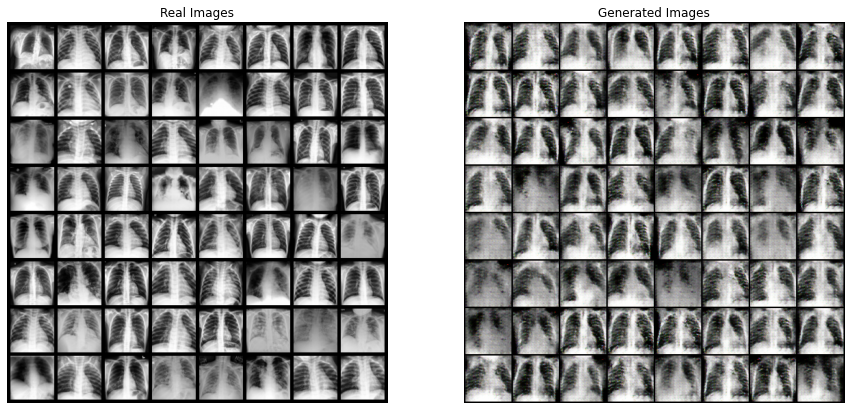

Generator and Discriminator Comparison for Learning Rate - 0.01 and Batch size - 128


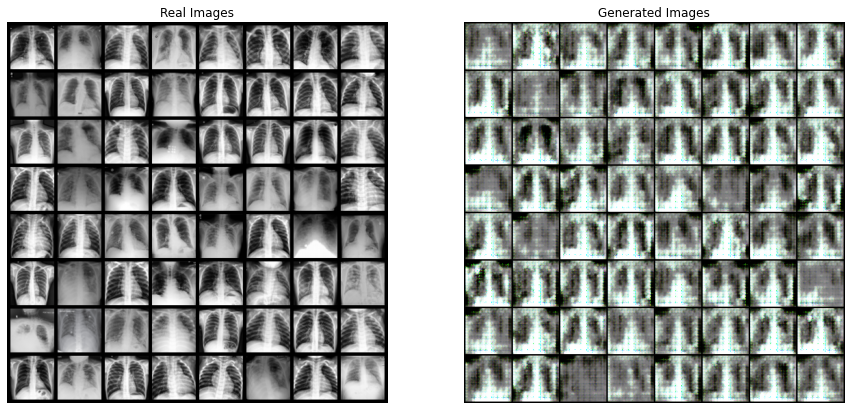

Generator and Discriminator Comparison for Learning Rate - 0.01 and Batch size - 256


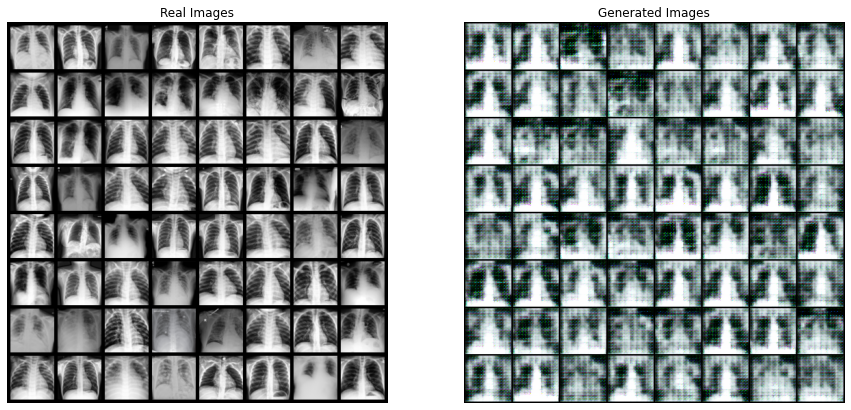

In [29]:
lr = [0.001,0.01]
batch_size = [64,128,256]

for i in lr:
    for j in batch_size:
        load_model_and_plot(f'generator_{i}_{j}.pth',f'discriminator_{i}_{j}.pth',i,j)
        

In [30]:
# Function to generate and save fake images
def generate_and_save_fake_images(generator, num_images, save_dir):
    generator.eval()
    os.makedirs(save_dir, exist_ok=True)
    for i in range(num_images):
        with torch.no_grad():
            noise = torch.randn(1, nz, 1, 1, device=device)
            fake = generator(noise).detach().cpu()
        vutils.save_image(fake, os.path.join(save_dir, f'fake_image_{i+1:04d}.png'), normalize=True)

# Load the generator
netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load("generator_0.001_128.pth"))

# Generate and save fake images
generate_and_save_fake_images(netG, 1000, "fake_images")


In [32]:
for i in lr:
    for j in batch_size:
        # Load the generator
        netG = Generator(ngpu).to(device)
        netG.load_state_dict(torch.load(f'generator_{i}_{j}.pth'))
        generate_and_save_fake_images(netG,1000,f"fake_images_lr_{i}_bs_{j}")

In [61]:
def generate_and_save_fake_images_to_classes(generator, num_images_per_class, class_labels, save_dir):
    generator.eval()
    os.makedirs(save_dir, exist_ok=True)
    for label in class_labels:
        class_dir = os.path.join(save_dir, str(label))
        os.makedirs(class_dir, exist_ok=True)
        for i in range(num_images_per_class):
            with torch.no_grad():
                noise = torch.randn(1, nz, 1, 1, device=device)
                fake = generator(noise).detach().cpu()
            vutils.save_image(fake, os.path.join(class_dir, f'fake_image_{label}_{i+1:04d}.png'), normalize=True)
class_labels = ['Covid', 'Normal', 'Viral Pneumonia']  # Assuming you have 3 classes

netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load("generator_0.001_128.pth"))

generate_and_save_fake_images_to_classes(netG, 250, class_labels, "fake_images_per_class")


In [93]:
lr = [0.001,0.01]
batch_size = [64,128,256]
for i in lr:
    for j in batch_size:
        netG = Generator(ngpu).to(device)
        netG.load_state_dict(torch.load(f'generator_{i}_{j}.pth'))
        generate_and_save_fake_images_to_classes(netG, 250, class_labels, f"generated_images_generator_{i}_{j}/train")

In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import numpy as np

# Define a function to calculate the inception score
def inception_score(images, batch_size=64, splits=10):
    # Initialize Inception V3 model
    inception_model = models.inception_v3(pretrained=True, transform_input=False, aux_logits=True).cuda()
    inception_model.eval()
    up = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=False).cuda()

    # Define transformation for images
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Define data loader for generated images
    fake_dataset = ImageFolder(root=images, transform=transform)
    fake_loader = DataLoader(fake_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    preds = []
    with torch.no_grad():
        for batch in tqdm(fake_loader, desc='Calculating Inception Score'):
            batch = batch[0].cuda()
            batch = up(batch)
            pred = inception_model(batch)
            preds.append(F.softmax(pred, dim=1).cpu().numpy())

    preds = np.concatenate(preds, axis=0)

    # Calculate inception score
    scores = []
    for i in range(splits):
        part = preds[i * (preds.shape[0] // splits): (i + 1) * (preds.shape[0] // splits), :]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
        kl = np.mean(np.sum(kl, 1))
        scores.append(np.exp(kl))

    return np.mean(scores), np.std(scores)

if __name__ == "__main__":
    fake_images_path = "fake_images_per_class/train"  # Path to the folder containing generated images
    is_mean, is_std = inception_score(fake_images_path)
    print(f"Inception Score: Mean={is_mean}, Std={is_std}")


Calculating Inception Score: 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]

Inception Score: Mean=1.50596022605896, Std=0.05427131801843643


In [95]:
lr = [0.001,0.01]
batch_size = [64,128,256]
for i in lr:
    for j in batch_size:
        fake_images_path = f"generated_images/generated_images_generator_{i}_{j}/train" 
        is_mean, is_std = inception_score(fake_images_path)
        print(f"Inception Score for lr - {i} and batch size - {j}: Mean={is_mean}, Std={is_std}")

Calculating Inception Score: 100%|██████████| 12/12 [00:03<00:00,  3.91it/s]


Inception Score for lr - 0.001 and batch size - 64: Mean=2.0473742485046387, Std=0.08948302268981934


Calculating Inception Score: 100%|██████████| 12/12 [00:03<00:00,  3.81it/s]


Inception Score for lr - 0.001 and batch size - 128: Mean=1.5210232734680176, Std=0.07066598534584045


Calculating Inception Score: 100%|██████████| 12/12 [00:03<00:00,  3.91it/s]


Inception Score for lr - 0.001 and batch size - 256: Mean=1.5183805227279663, Std=0.026611313223838806


Calculating Inception Score: 100%|██████████| 12/12 [00:03<00:00,  3.96it/s]


Inception Score for lr - 0.01 and batch size - 64: Mean=1.8379695415496826, Std=0.05285049229860306


Calculating Inception Score: 100%|██████████| 12/12 [00:03<00:00,  3.86it/s]


Inception Score for lr - 0.01 and batch size - 128: Mean=1.7150752544403076, Std=0.05082881823182106


Calculating Inception Score: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]

Inception Score for lr - 0.01 and batch size - 256: Mean=1.774658441543579, Std=0.06145356968045235


Generator and Discriminator Comparison for Learning Rate - 0.001 and Batch size - 64


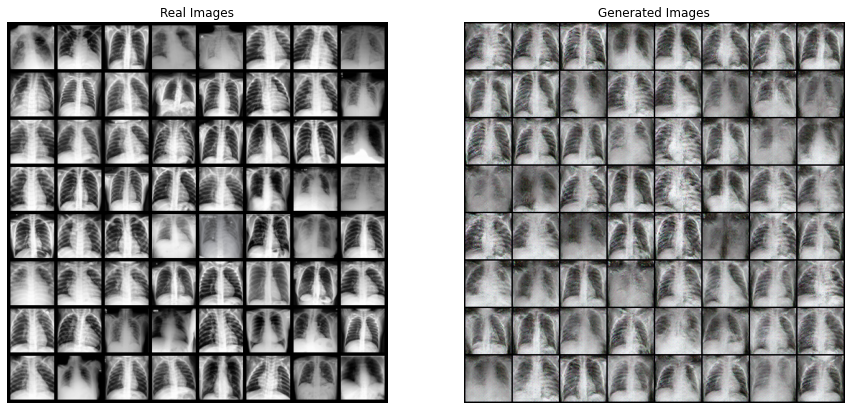

In [92]:
i = 0.001
j=64
load_model_and_plot(f'generator_{i}_{j}.pth',f'discriminator_{i}_{j}.pth',i,j)

In [98]:
netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load("u_net_weights/generator_0.0001_64_500.pth"))
img_path = 'u_net_images/generator_0.0001_64_500/train'
generate_and_save_fake_images_to_classes(netG, 250, class_labels, img_path)

is_mean, is_std = inception_score(img_path)
print(f"Inception Score: Mean={is_mean}, Std={is_std}")

Calculating Inception Score: 100%|██████████| 12/12 [00:03<00:00,  3.91it/s]

Inception Score: Mean=1.8025188446044922, Std=0.07335442304611206


In [101]:
netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load("u_net_weights/generator_0.0001_256.pth"))
img_path = 'u_net_images/generator_0.0001_256/train'
generate_and_save_fake_images_to_classes(netG, 250, class_labels, img_path)

is_mean, is_std = inception_score(img_path)
print(f"Inception Score: Mean={is_mean}, Std={is_std}")

Calculating Inception Score: 100%|██████████| 12/12 [00:03<00:00,  3.95it/s]

Inception Score: Mean=1.2830878496170044, Std=0.028744366019964218


In [102]:
netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load("u_net_weights/generator_0.0001_64.pth"))
img_path = 'u_net_images/generator_0.0001_64/train'
generate_and_save_fake_images_to_classes(netG, 250, class_labels, img_path)

is_mean, is_std = inception_score(img_path)
print(f"Inception Score: Mean={is_mean}, Std={is_std}")

Calculating Inception Score: 100%|██████████| 12/12 [00:03<00:00,  3.88it/s]

Inception Score: Mean=1.6762115955352783, Std=0.05686347559094429


In [103]:
netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load("u_net_weights/generator_0.0001_64_500.pth"))
img_path = 'u_net_images/generator_0.0001_64_500/train'
generate_and_save_fake_images_to_classes(netG, 250, class_labels, img_path)

is_mean, is_std = inception_score(img_path)
print(f"Inception Score: Mean={is_mean}, Std={is_std}")

Calculating Inception Score: 100%|██████████| 12/12 [00:02<00:00,  4.00it/s]

Inception Score: Mean=1.836525559425354, Std=0.08617131412029266


In [104]:
netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load("u_net_weights/generator_0.001_128.pth"))
img_path = 'u_net_images/generator_0.001_128/train'
generate_and_save_fake_images_to_classes(netG, 250, class_labels, img_path)

is_mean, is_std = inception_score(img_path)
print(f"Inception Score: Mean={is_mean}, Std={is_std}")

Calculating Inception Score: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]

Inception Score: Mean=1.8121013641357422, Std=0.13476799428462982


Generator and Discriminator Comparison for Learning Rate - 0.0001 and Batch size - 64


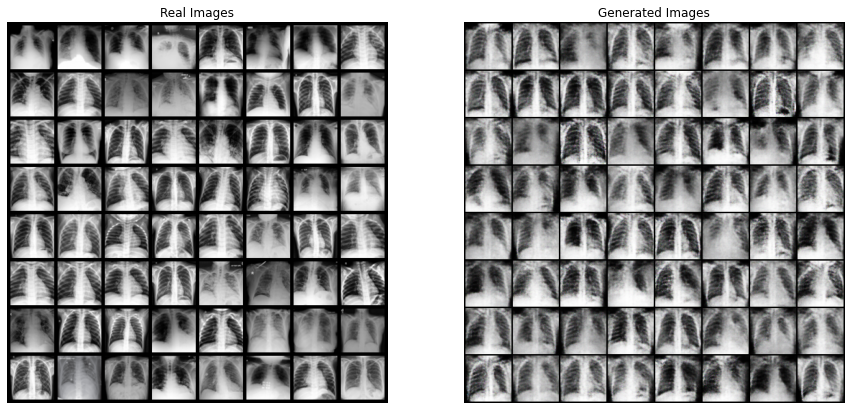

In [106]:
# lr = [0.001,0.01]
# batch_size = [64,128,256]
load_model_and_plot('u_net_weights/generator_0.0001_64_500.pth','discriminator_0.01_64.pth',0.0001,64)

In [107]:
netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load("u_net_weights/generator_0.0001_128.pth"))
img_path = 'u_net_images/generator_0.0001_128/train'
generate_and_save_fake_images_to_classes(netG, 250, class_labels, img_path)

is_mean, is_std = inception_score(img_path)
print(f"Inception Score: Mean={is_mean}, Std={is_std}")

Calculating Inception Score: 100%|██████████| 12/12 [00:03<00:00,  3.64it/s]

Inception Score: Mean=1.6966552734375, Std=0.041869066655635834
